In [142]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import json
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

In [143]:
df = pd.read_csv("All_Diets_cleaned.csv")

In [144]:
df.head(10)

,Recipe_name,Protein(g),Carbs(g),Fat(g),Extraction_day,Extraction_time,Diet_type_dash,Diet_type_keto,Diet_type_mediterranean,Diet_type_paleo,...,Cuisine_type_italian,Cuisine_type_japanese,Cuisine_type_kosher,Cuisine_type_mediterranean,Cuisine_type_mexican,Cuisine_type_middle eastern,Cuisine_type_nordic,Cuisine_type_south american,Cuisine_type_south east asian,Cuisine_type_world
0,bone broth from nom nom,5.22,1.29,3.20,2022-10-16,17:20:09,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,effect asian glazed pork sides sweet crispy ap...,181.55,28.62,146.14,2022-10-16,17:20:09,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
2,pumpkin pie,30.91,302.59,96.76,2022-10-16,17:20:09,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,strawberry guacamole,9.62,75.78,59.89,2022-10-16,17:20:09,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,asian cauliflower fried rice from nom nom,39.84,54.08,71.55,2022-10-16,17:20:09,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
5,shrimp stuffed mushrooms,68.62,34.15,42.44,2022-10-16,17:20:09,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
6,pumpkin pie,30.03,275.88,97.68,2022-10-16,17:20:09,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
7,autoimmune pesto,4.25,14.15,72.90,2022-10-16,17:20:09,False,False,False,True,...,True,False,False,False,False,False,False,False,False,False
8,baked banana chip encrusted french toast,152.88,1874.52,385.80,2022-10-16,17:20:09,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
9,vietnamese pho pressure cooker noodle soup,602.91,274.87,400.01,2022-10-16,17:20:09,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False


In [145]:
recipes = df["Recipe_name"]
recipes[597]

'crumble'

In [146]:
tokenized_recipes = [word_tokenize(sentence) for sentence in recipes]
model = Word2Vec(sentences=tokenized_recipes, vector_size=75, window=5, min_count=1, workers=4)


In [147]:
with open("tagged_diets.json","r") as file:
    tags_dictionary = json.load(file)

tags_dictionary[:10]

[{'nouns': ['bone', 'broth', 'nom'], 'adjectives': ['nom']},
 {'nouns': ['effect', 'pork', 'sides', 'appetizer'],
  'adjectives': ['asian', 'crispy']},
 {'nouns': ['pumpkin', 'pie'], 'adjectives': []},
 {'nouns': ['strawberry', 'guacamole'], 'adjectives': []},
 {'nouns': ['cauliflower', 'rice', 'nom'], 'adjectives': ['asian', 'nom']},
 {'nouns': ['shrimp', 'mushrooms'], 'adjectives': []},
 {'nouns': ['pumpkin', 'pie'], 'adjectives': []},
 {'nouns': ['autoimmune', 'pesto'], 'adjectives': []},
 {'nouns': ['banana', 'chip', 'toast'], 'adjectives': ['french']},
 {'nouns': ['pho', 'pressure', 'cooker', 'soup'],
  'adjectives': ['vietnamese', 'noodle']}]

In [148]:
model_vocab = set(model.wv.index_to_key)
nouns_features_list = []
adjectives_features_list = []
for index,tags in enumerate(tags_dictionary):
    nouns = tags["nouns"]
    adjectives = tags["adjectives"]
    if adjectives == []:
        adjectives_features = [0 for _ in range(75)]
    else:
        allowed_adjectives = [adjective for adjective in adjectives if adjective in model_vocab]
        if allowed_adjectives == []:
            adjectives_features = [0 for _ in range(75)]
        else:
            adjectives_features = np.average([model.wv[adj] for adj in allowed_adjectives],axis=0)
    if nouns == []:
            allowed_words = [word for word in recipes[index].split() if word in model_vocab]
            nouns_features = np.average([model.wv[word] for word in allowed_words],axis=0)
    else:
        allowed_nouns = [noun for noun in recipes[index].split() if noun in model_vocab]
        if allowed_nouns==[]:
            allowed_words = [word for word in recipes[index].split() if word in model_vocab]
            nouns_features = np.average([model.wv[word] for word in allowed_words],axis=0)
        else:
            nouns_features = np.average([model.wv[noun] for noun in allowed_nouns],axis=0)
    nouns_features_list.append(nouns_features)
    adjectives_features_list.append(adjectives_features)
    

In [149]:
nouns_features_list = np.array(nouns_features_list)
adjectives_features_list = np.array(adjectives_features_list)

In [150]:
embeddings_features = np.hstack((nouns_features_list,adjectives_features_list))

In [151]:
# Aplicar T-SNE
tsne = TSNE(n_components=3, random_state=0)
X_embedded = tsne.fit_transform(embeddings_features)


(7805, 5)


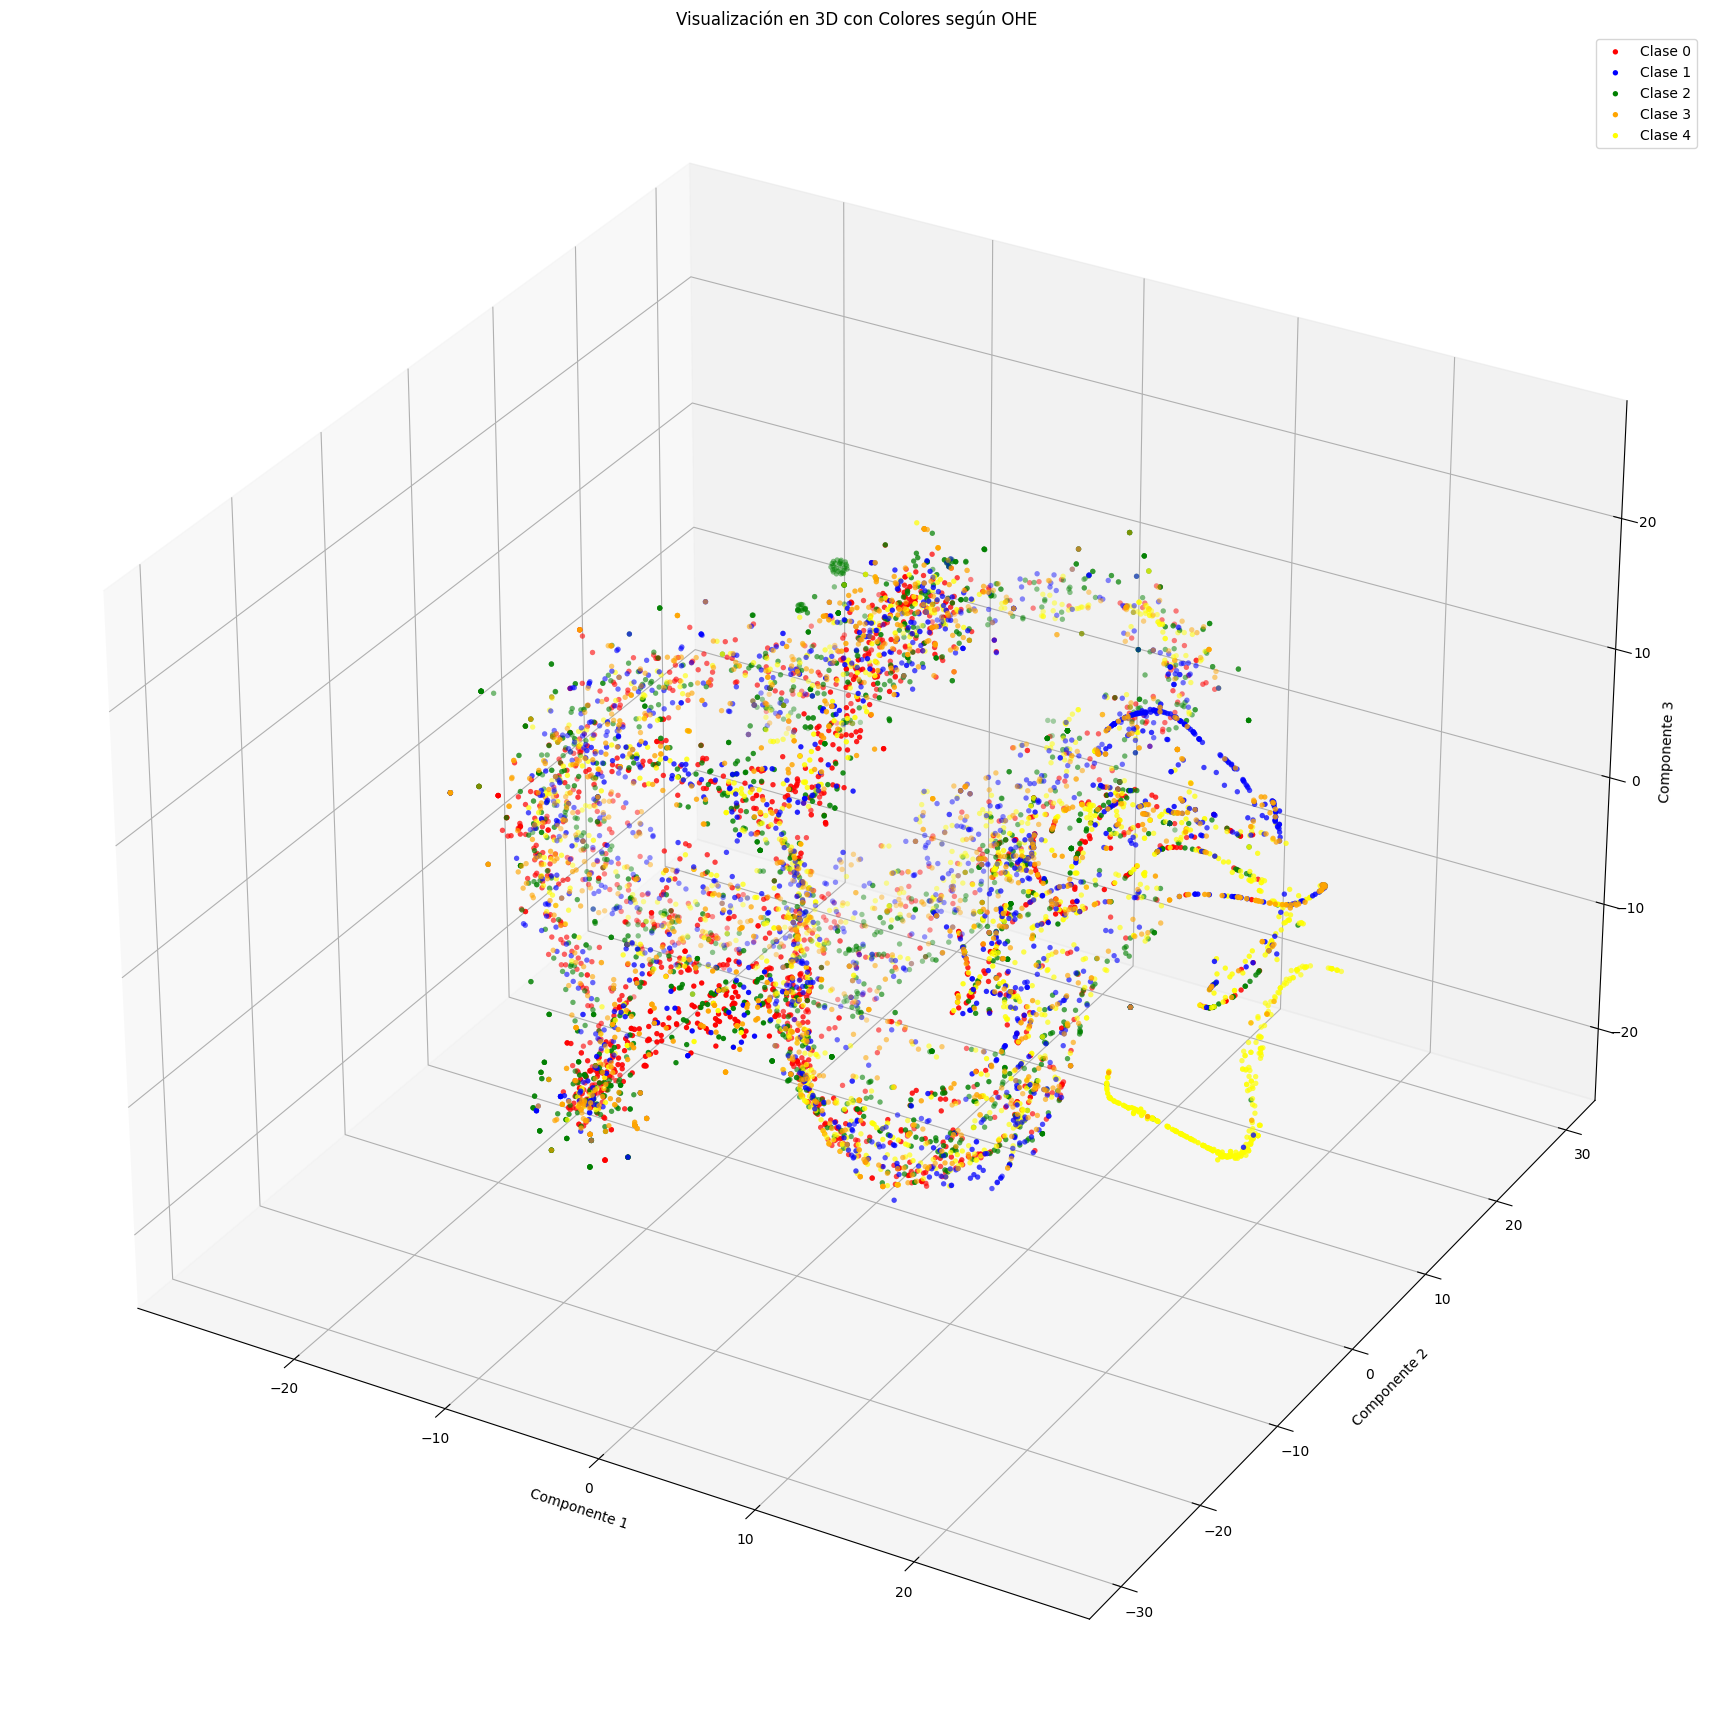

In [155]:
types = df.iloc[:,6:11]
types.to_numpy(dtype=int)
print(types.shape)
colors = ['red', 'blue', 'green', 'orange','yellow']

color_indices = np.argmax(types, axis=1)

point_colors = [colors[idx] for idx in color_indices]

fig = plt.figure(figsize=(22,22))
ax = fig.add_subplot(111, projection='3d')

# Iterar sobre cada clase y graficar puntos con su color correspondiente
for i in range(len(colors)):
    ax.scatter(X_embedded[color_indices == i, 0], X_embedded[color_indices == i, 1], X_embedded[color_indices == i, 2],
               c=colors[i], label=f'Clase {i}', marker='o', edgecolor='none', s=15)

ax.set_title('Visualización en 3D con Colores según OHE')
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
ax.legend()

plt.show()